In [ ]:
import os 
os.environ['CUDA_VISIBLE_DEVICES']='3'
os.environ['DDE_BACKEND']='pytorch'

In [ ]:
import deepxde as dde 
import torch 
import numpy as np 
import matplotlib.pyplot as plt

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/userhome/jeon_mg/miniforge3/envs/pinn_torch/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [ ]:
# Masses
m1 = 1.0
m2 = 1.0
# Spring constants
k1 = 5.0
k2 = 2.0
# Natural lengths
L1 = 0.5
L2 = 0.5
# Friction coefficients
b1 = 0.1
b2 = 0.1

# Initial conditions
d1_0 = 0.5
d2_0 = 3.25

v1_0 = 0.0
v2_0 = 0.0

# maximum time to simulate
t_max = 5

In [ ]:
def pde(t, X):
    dx1_t = dde.grad.jacobian(X, t, i=0, j=0)
    dx2_t = dde.grad.jacobian(X, t, i=1, j=0)

    dx1_tt = dde.grad.hessian(X, t, component=0, i=0, j=0)
    dx2_tt = dde.grad.hessian(X, t, component=1, i=0, j=0)

    x1 = X[:, 0:1]
    x2 = X[:, 1:2]

    pde1 = m1*dx1_tt + b1*dx1_t + k1*(x1-L1) - k2*(x2-x1-L2)
    pde2 = m2*dx2_tt + b2*dx2_t + k2*(x2-x1-L2)
    
    return [pde1, pde2]

In [ ]:
def boundary(t, on_boundary):
    return on_boundary and np.isclose(t[0], 0)

In [ ]:
geom = dde.geometry.Interval(0, t_max)

ic_x1 = dde.DirichletBC(geom, lambda t: d1_0, boundary, component=0)
ic_x2 = dde.DirichletBC(geom, lambda t: d2_0, boundary, component=1)
ic_v1 = dde.OperatorBC(geom, lambda t, X, _: dde.grad.jacobian(X, t, i=0, j=0), boundary)
ic_v2 = dde.OperatorBC(geom, lambda t, X, _: dde.grad.jacobian(X, t, i=1, j=0), boundary)

In [ ]:
data = dde.data.PDE(geom,
                    pde,
                    [ic_x1, ic_x2, ic_v1, ic_v2],
                    num_domain=5000,
                    num_boundary=200,
                    num_test=1000)

In [ ]:
layer_size = [1] + [20]*3 + [2]
activation = 'tanh'
initializer = 'Glorot uniform'

net = dde.maps.FNN(layer_size, activation, initializer)

In [ ]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
'compile' took 0.402745 s



Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [8.95e+00, 6.91e-01, 2.50e-01, 1.06e+01, 5.31e-02, 5.67e-02]    [9.06e+00, 6.84e-01, 2.50e-01, 1.06e+01, 5.31e-02, 5.67e-02]    []  
1000      [1.87e-01, 2.11e-01, 1.34e-01, 9.45e-02, 2.40e-04, 4.48e-04]    [1.92e-01, 2.19e-01, 1.34e-01, 9.45e-02, 2.40e-04, 4.48e-04]    []  
2000      [1.28e-01, 7.81e-02, 1.44e-01, 3.38e-02, 4.05e-05, 6.49e-06]    [1.31e-01, 7.28e-02, 1.44e-01, 3.38e-02, 4.05e-05, 6.49e-06]    []  
3000      [9.35e-02, 3.88e-02, 7.88e-02, 1.18e-02, 2.54e-05, 1.11e-04]    [9.72e-02, 3.17e-02, 7.88e-02, 1.18e-02, 2.54e-05, 1.11e-04]    []  
4000      [4.10e-02, 1.69e-02, 1.93e-02, 2.74e-03, 3.94e-05, 5.93e-05]    [4.10e-02, 1.30e-02, 1.93e-02, 2.74e-03, 3.94e-05, 5.93e-05]    []  
5000      [1.16e-02, 7.57e-03, 2.12e-03, 3.60e-04, 4.01e-06, 5.90e-05]    [9.75e-03, 5.66e-03, 2.12e-03, 3.60e-04, 4

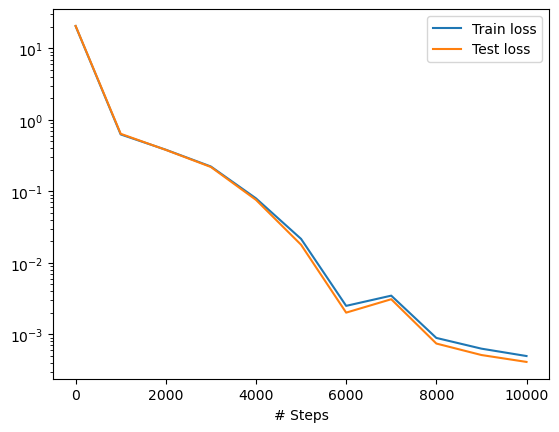

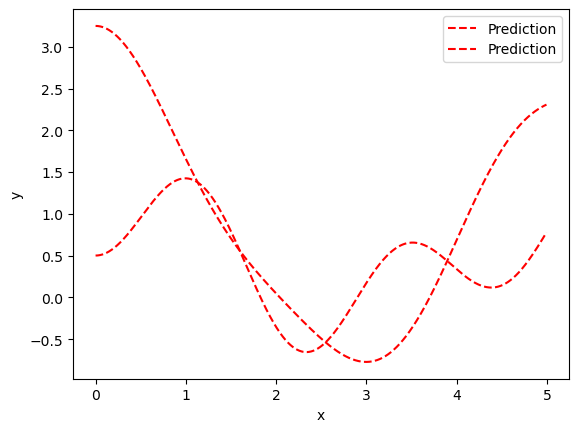

In [ ]:
losshistory, train_state = model.train(iterations=10000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [ ]:
from scipy.integrate import odeint

In [ ]:
def vectorfield(w, t, p):
    x1, y1, x2, y2 = w 
    m1, m2, k1, k2, L1, L2, b1, b2 = p 

    f = [y1,
        (-b1*y1 - k1*(x1-L1) + k2*(x2-x1-L2))/m1,
        y2,
        (-b2*y2 - k2*(x2-x1-L2))/m2]
    return f 

abserr = 1.0e-8
relerr = 1.0e-8
stoptime = t_max 
numpoints = 150
t = np.linspace(0, stoptime, 5000).reshape(-1, 1)

p = [m1, m2, k1, k2, L1, L2, b1, b2]
w0 = [d1_0, v1_0, d2_0, v2_0]

wsol = odeint(vectorfield, w0, t.squeeze(), args=(p,), atol=abserr, rtol=relerr)

In [ ]:
wsol.shape

(5000, 4)

In [ ]:
pinn = model.predict(t)
pinn.shape

(5000, 2)

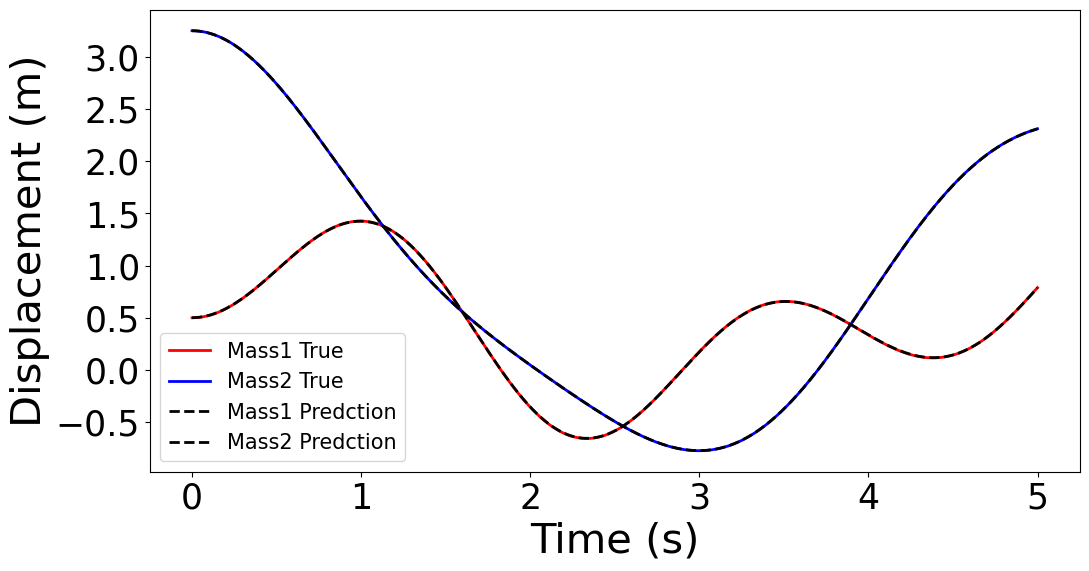

In [ ]:
x1_true = wsol[:, 0]
x2_true = wsol[:, 2]

x1_pinn = pinn[:, 0]
x2_pinn = pinn[:, 1]

lw = 2
plt.figure(figsize=(12, 6))

plt.plot(t, x1_true, label='Mass1 True', c='r', lw=lw)
plt.plot(t, x2_true, label='Mass2 True', c='b', lw=lw)

plt.plot(t, x1_pinn, label='Mass1 Predction', linestyle='dashed', c='k', lw=lw)
plt.plot(t, x2_pinn, label='Mass2 Predction', linestyle='dashed', c='k', lw=lw)

plt.legend(fontsize=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Time (s)', fontsize=30)
plt.ylabel('Displacement (m)', fontsize=30)
plt.show()

In [ ]:
dde.metrics.l2_relative_error(x1_true, x1_pinn)

0.0018799716748410398

In [ ]:
dde.metrics.l2_relative_error(x2_true, x2_pinn)

0.00047848647465985176

# extrapolate

In [ ]:
def vectorfield(w, t, p):
    x1, y1, x2, y2 = w 
    m1, m2, k1, k2, L1, L2, b1, b2 = p 

    f = [y1,
        (-b1*y1 - k1*(x1-L1) + k2*(x2-x1-L2))/m1,
        y2,
        (-b2*y2 - k2*(x2-x1-L2))/m2]
    return f 

abserr = 1.0e-8
relerr = 1.0e-8
stoptime = t_max + 5
numpoints = 150
t = np.linspace(0, stoptime, 10000).reshape(-1, 1)

p = [m1, m2, k1, k2, L1, L2, b1, b2]
w0 = [d1_0, v1_0, d2_0, v2_0]

wsol = odeint(vectorfield, w0, t.squeeze(), args=(p,), atol=abserr, rtol=relerr)

In [ ]:
pinn = model.predict(t)

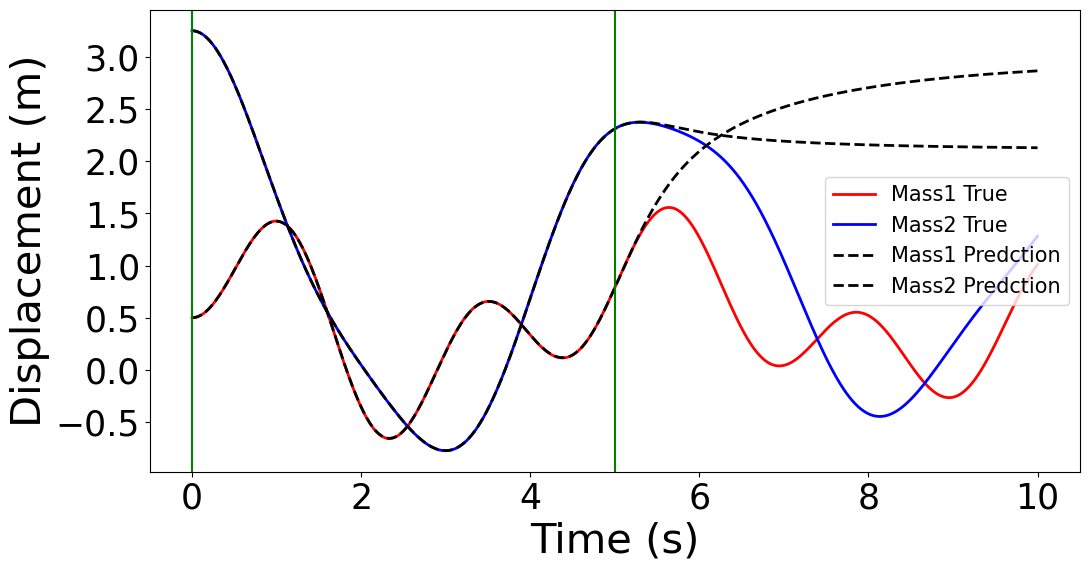

In [ ]:
x1_true = wsol[:, 0]
x2_true = wsol[:, 2]

x1_pinn = pinn[:, 0]
x2_pinn = pinn[:, 1]

lw = 2
plt.figure(figsize=(12, 6))

plt.plot(t, x1_true, label='Mass1 True', c='r', lw=lw)
plt.plot(t, x2_true, label='Mass2 True', c='b', lw=lw)

plt.plot(t, x1_pinn, label='Mass1 Predction', linestyle='dashed', c='k', lw=lw)
plt.plot(t, x2_pinn, label='Mass2 Predction', linestyle='dashed', c='k', lw=lw)

plt.legend(fontsize=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Time (s)', fontsize=30)
plt.ylabel('Displacement (m)', fontsize=30)
plt.axvline(0, color='g')
plt.axvline(t_max, color='g')
plt.show()